In [1]:
import pandas as pd

In [2]:
# Read in cluster data
cluster_df = pd.read_csv('data/listings_clustered.csv') 

cluster_df = cluster_df.rename(columns={"id": "listing_id"})


print(cluster_df.shape)
print(cluster_df.columns)
print(cluster_df["listing_id"].nunique())

(13254, 2)
Index(['listing_id', 'cluster_kmeans'], dtype='object')
13254


In [3]:
# I saved like this: results_df.to_csv(f"results_df_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
# Read in results_df
results_df = pd.read_csv('results_df_20251118_125309.csv')
results_df["Review"] = results_df["Review"].str.replace(r"<br\s*/?>", "", regex=True)



In [4]:
merged_df = results_df[results_df["listing_id"].isin(cluster_df["listing_id"])].merge(cluster_df, on="listing_id", how="left")
merged_df.head()

id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0  1        0.0      0.424      0.576          0.9118     0.004214   
1  2        0.0      0.748      0.252          0.4019     0.004356   
2  3        0.0      1.000      0.000          0.0000     0.008691   
3  4        0.0      0.455      0.545          0.7184     0.001651   
4  5        0.0      0.541      0.459          0.7783     0.001498   

   roberta_neu  roberta_pos    listing_id        date  reviewer_id  \
0     0.090394     0.905392  7.374532e+17  2023-07-13  168460048.0   
1     0.229301     0.766343  7.374532e+17  2023-07-13  168460048.0   
2     0.473369     0.517940  7.374532e+17  2023-07-13  168460048.0   
3     0.021786     0.976563  7.374532e+17  2023-07-13  168460048.0   
4     0.010797     0.987705  2.907347e+06  2024-08-18   11387465.0   

  reviewer_name                                             Review  \
0       Shianne  Elizabeth was super responsive and was kind en...   
1       Shianne  Place matched the description and photos and w...   
2       Shianne  Everything is within walking distance, especia...   
3       Shianne       Enjoyed my stay, would definitely book again   
4        Yannis  Thanks for having us - we loved staying in the...   

   cluster_kmeans  
0              10  
1              10  
2              10  
3              10  
4               7

In [5]:
# Print row with cluster_kmeans = 100
merged_df[merged_df["cluster_kmeans"] == 100]

id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
49         50        0.0      0.200      0.800          0.8402     0.001995   
50         51        0.0      0.213      0.787          0.5719     0.016735   
1272     1869        0.0      0.855      0.145          0.5267     0.001839   
1273     1870        0.0      0.503      0.497          0.6049     0.005439   
1274     1871        0.0      1.000      0.000          0.0000     0.009811   
...       ...        ...        ...        ...             ...          ...   
92658  137291        0.0      0.518      0.482          0.4201     0.001745   
92874  137574        0.0      0.764      0.236          0.5719     0.001901   
92875  137575        0.0      1.000      0.000          0.0000     0.001662   
92876  137576        0.0      0.710      0.290          0.5984     0.002310   
92877  137577        0.0      0.707      0.293          0.4404     0.001821   

       roberta_neu  roberta_pos  listing_id        date  reviewer_id  \
49        0.018420     0.979584  42501574.0  2021-08-06    6528841.0   
50        0.309219     0.674047  42501574.0  2021-08-06    6528841.0   
1272      0.095416     0.902745  42501574.0  2023-05-30  231683789.0   
1273      0.169432     0.825129  42501574.0  2023-05-30  231683789.0   
1274      0.547021     0.443168  42501574.0  2023-05-30  231683789.0   
...            ...          ...         ...         ...          ...   
92658     0.032462     0.965793  42501574.0  2023-06-22  328750945.0   
92874     0.021708     0.976391  42501574.0  2023-10-23   33146793.0   
92875     0.120740     0.877598  42501574.0  2023-10-23   33146793.0   
92876     0.061410     0.936280  42501574.0  2023-10-23   33146793.0   
92877     0.085184     0.912995  42501574.0  2023-10-23   33146793.0   

      reviewer_name                                             Review  \
49            Joost                Great location, beautiful apartment   
50            Joost                            Excellent communication   
1272       Samantha  The Apartments are centrally located in an ide...   
1273       Samantha               The street is quite and safe feeling   
1274       Samantha  There are stores/ restaurants right out the do...   
...             ...                                                ...   
92658      Sigridur                        Really recommend this place   
92874       Lindsay  The flat was perfect and had everything I need...   
92875       Lindsay  It’s in a very walkable location, close to the...   
92876       Lindsay  Aperon was always very responsive to my inquir...   
92877       Lindsay            I hope to stay here again in the future   

       cluster_kmeans  
49                100  
50                100  
1272              100  
1273              100  
1274              100  
...               ...  
92658             100  
92874             100  
92875             100  
92876             100  
92877             100  

[542 rows x 14 columns]

In [6]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import os

# Create output folder if it doesn't exist
os.makedirs("WordClouds15", exist_ok=True)

# ------------------------------------------------------
# 1. Detect probable names inside sentences
# ------------------------------------------------------
def find_probable_names(text):
    probable = set()
    sentences = re.split(r'(?<=[.!?])\s+', text)  # simple sentence split

    for sent in sentences:
        words = sent.split()
        for i, w in enumerate(words):
            # skip empty tokens
            if not w:
                continue

            # remove punctuation around token
            token = re.sub(r'^\W+|\W+$', '', w)

            # ignore empty after cleaning
            if not token:
                continue

            # rule: inside sentence AND starts uppercase AND rest lowercase
            if i > 0 and token[0].isupper() and token[1:].islower():
                probable.add(token.lower())
    return probable


# ------------------------------------------------------
# 2. Tokenizer using the rule above
# ------------------------------------------------------
def tokenize_filter_names(text, global_names):
    # split into words
    raw_tokens = re.findall(r"\b\w+\b", text)
    tokens = []

    for w in raw_tokens:
        lw = w.lower()

        # remove anything marked globally as a name
        if lw in global_names:
            continue

        tokens.append(lw)
    return tokens


# ------------------------------------------------------
# 3. Weighted contrastive word cloud
# ------------------------------------------------------
def make_weighted_wc(texts_main, texts_ref, title, ratio_threshold=1.2, min_freq=3, save_path=None):
    # Step A: collect all candidate names from both groups
    probable_names = set()
    for t in list(texts_main) + list(texts_ref):
        probable_names |= find_probable_names(str(t))

    # Step B: tokenize while filtering names
    main_tokens = []
    ref_tokens = []

    for t in texts_main:
        main_tokens.extend(tokenize_filter_names(str(t), probable_names))

    for t in texts_ref:
        ref_tokens.extend(tokenize_filter_names(str(t), probable_names))

    # Step C: frequency comparison
    c1 = Counter(main_tokens)
    c2 = Counter(ref_tokens)

    weights = {}
    for w, f_main in c1.items():
        if f_main < min_freq:
            continue
        f_ref = c2.get(w, 0) + 1e-6
        ratio = f_main / f_ref
        if ratio >= ratio_threshold:
            weights[w] = ratio

    if not weights:
        print(f"{title}: No distinctive words found.")
        return

    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()



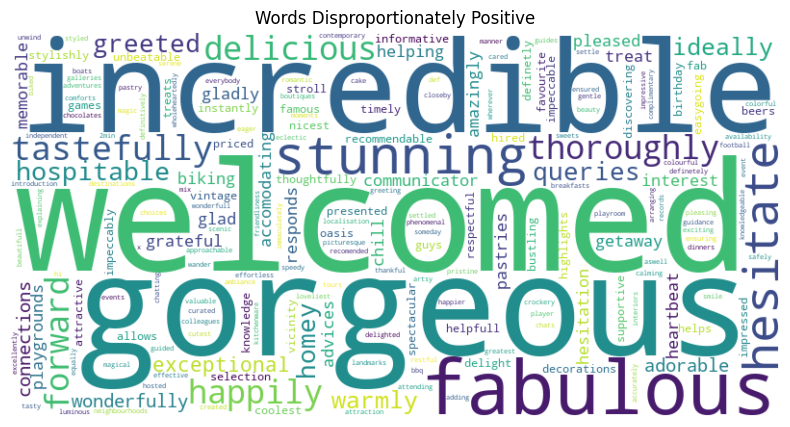

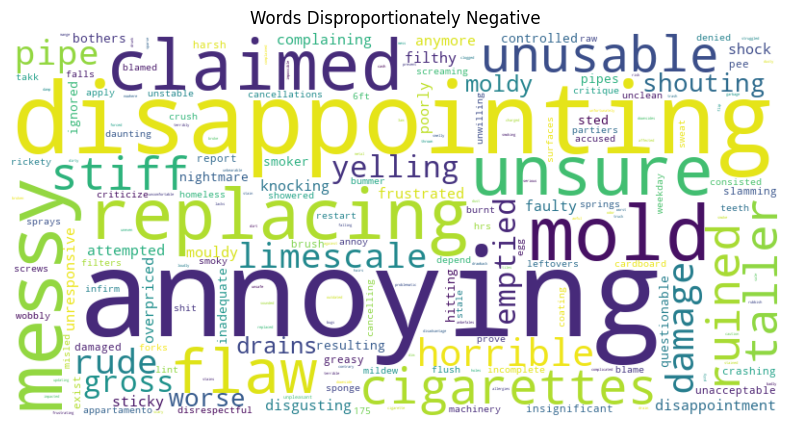

In [7]:
# Example usage
pos_texts = results_df.loc[results_df.roberta_neg < results_df.roberta_pos, "Review"]
neg_texts = results_df.loc[results_df.roberta_pos < results_df.roberta_neg, "Review"]

make_weighted_wc(pos_texts, neg_texts, "Words Disproportionately Positive")
make_weighted_wc(neg_texts, pos_texts, "Words Disproportionately Negative")

Saved: WordClouds15/C0P.png


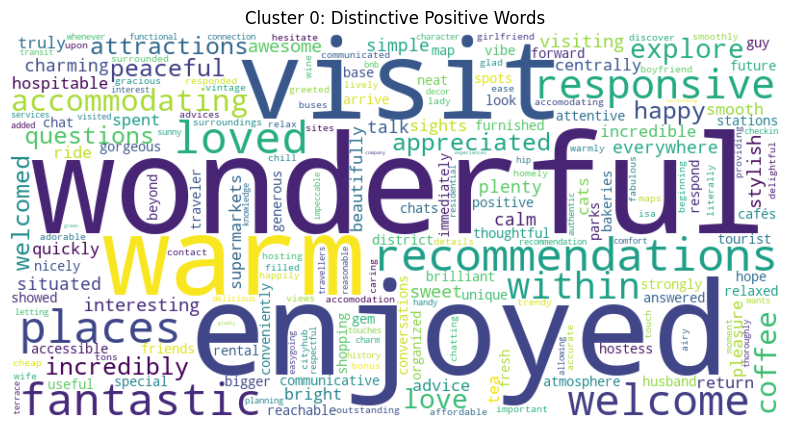

Saved: WordClouds15/C0N.png


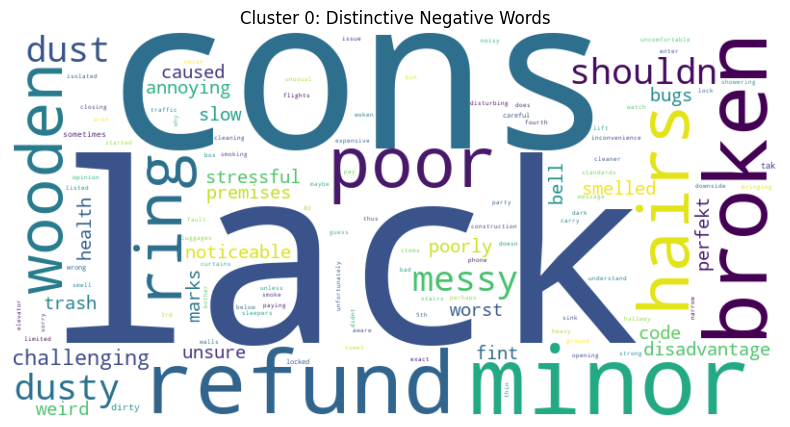

Saved: WordClouds15/C1P.png


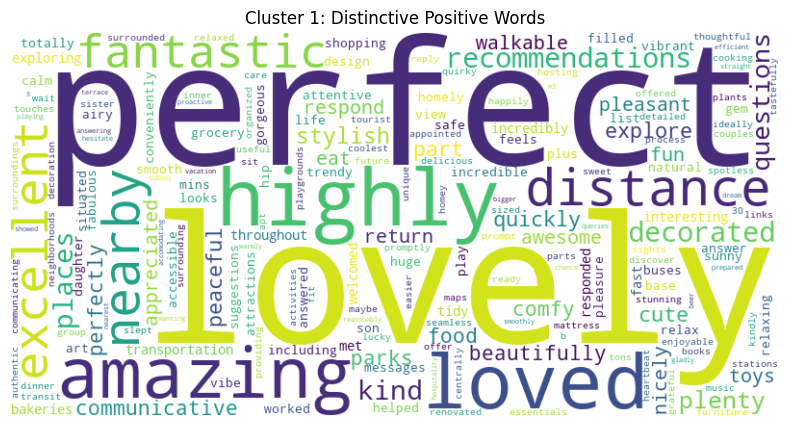

Saved: WordClouds15/C1N.png


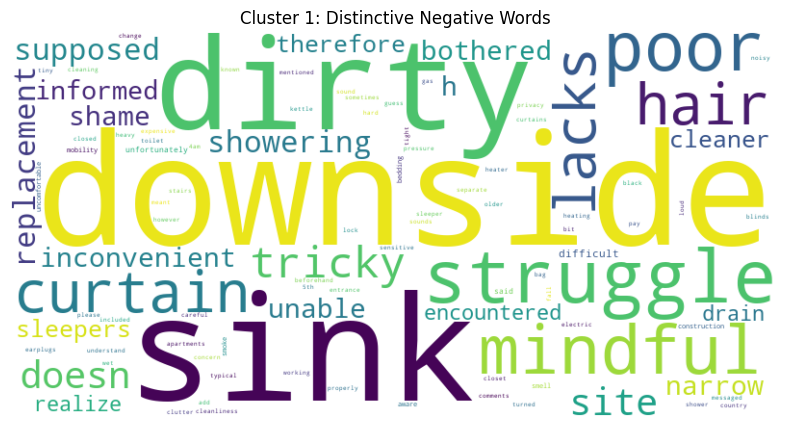

Saved: WordClouds15/C2P.png


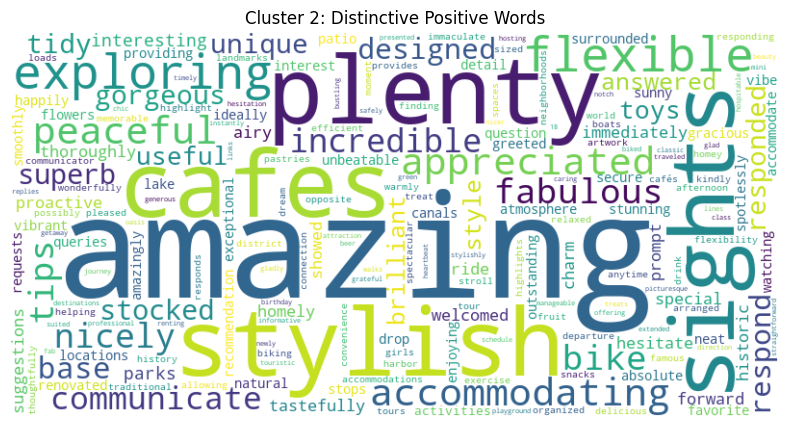

Saved: WordClouds15/C2N.png


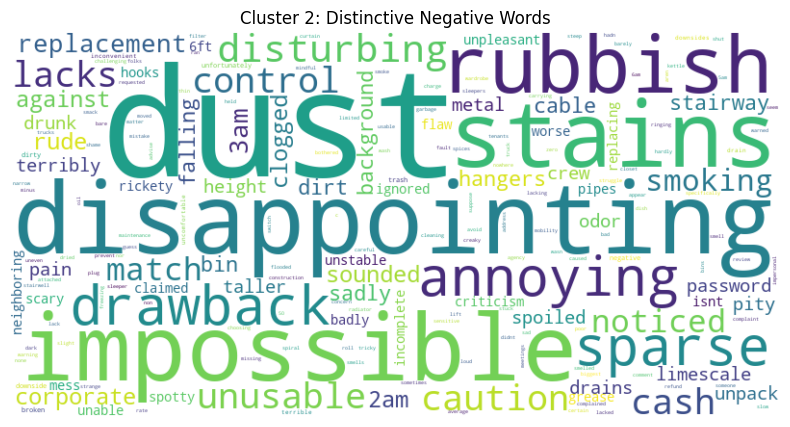

Saved: WordClouds15/C3P.png


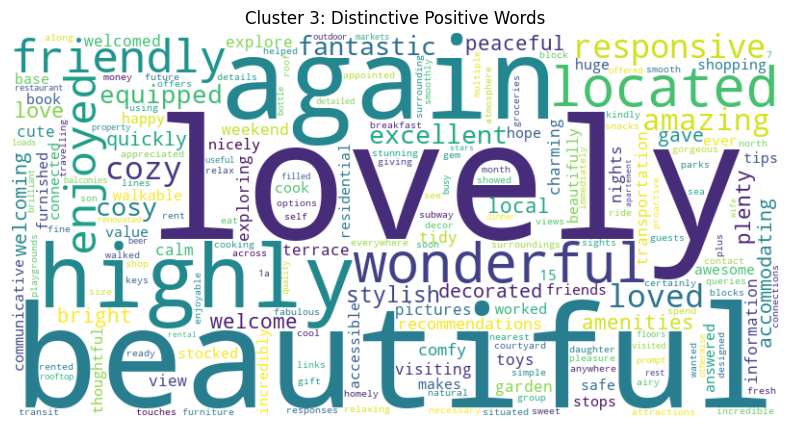

Saved: WordClouds15/C3N.png


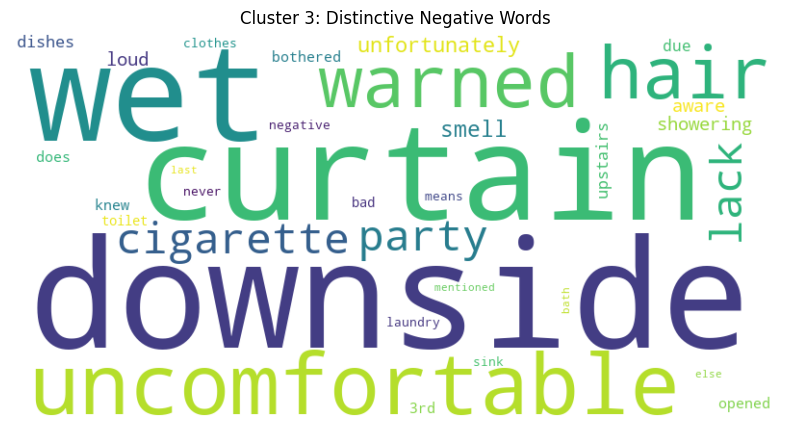

Saved: WordClouds15/C4P.png


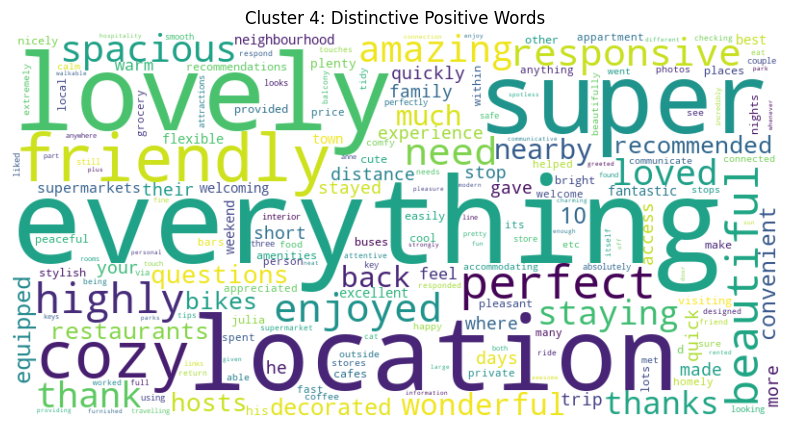

Saved: WordClouds15/C4N.png


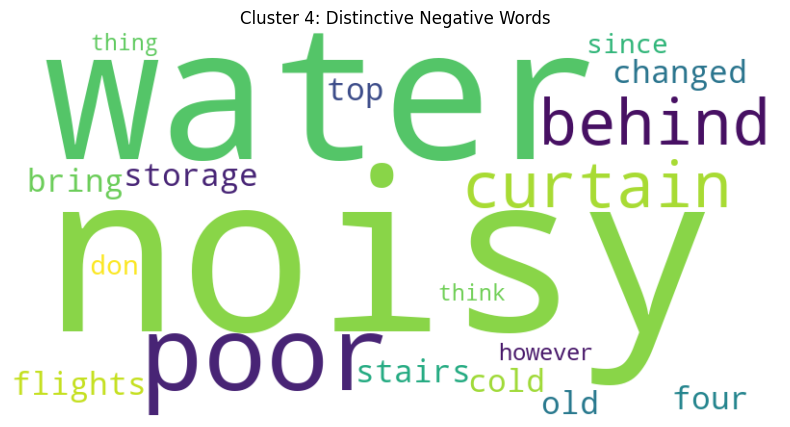

Saved: WordClouds15/C5P.png


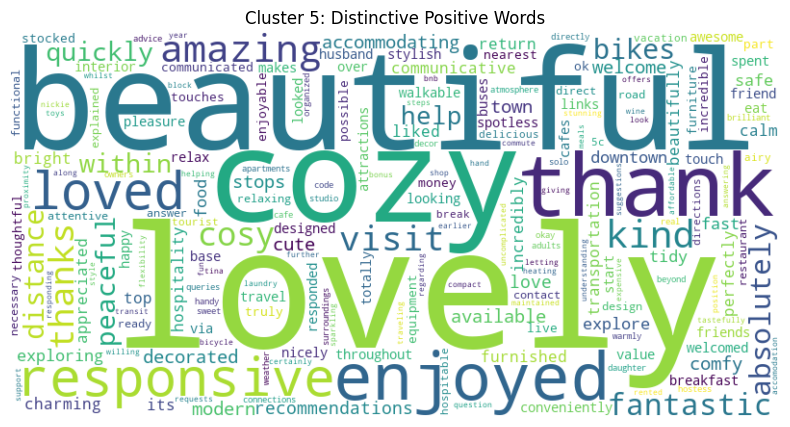

Saved: WordClouds15/C5N.png


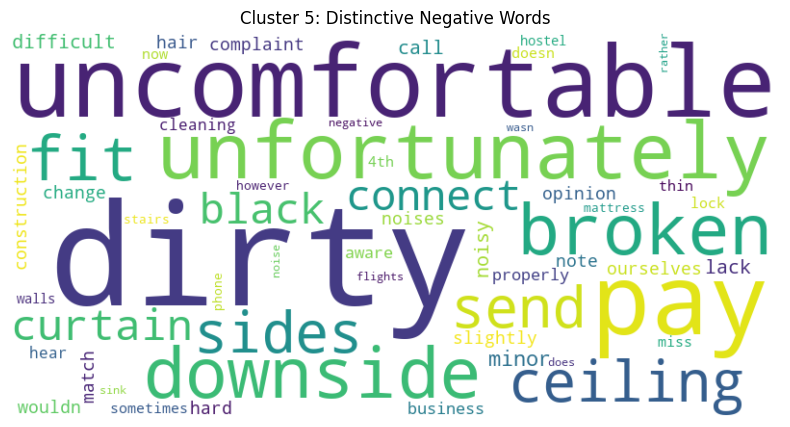

Saved: WordClouds15/C6P.png


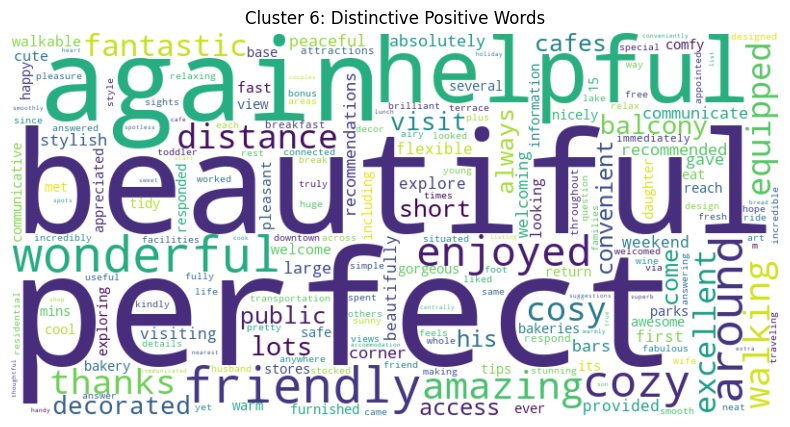

Saved: WordClouds15/C6N.png


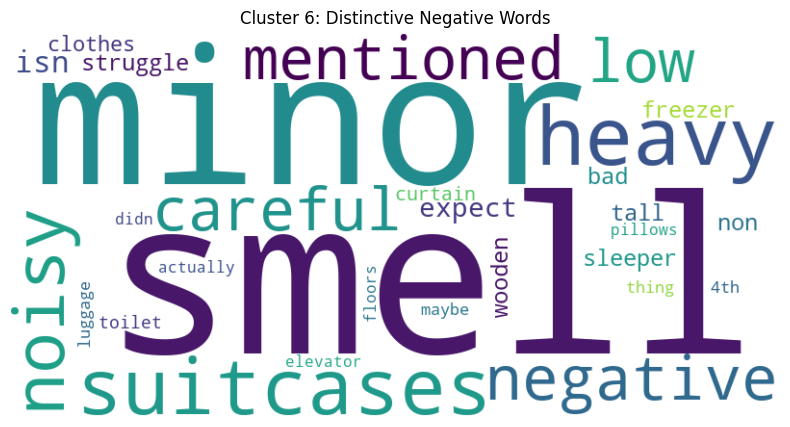

Saved: WordClouds15/C7P.png


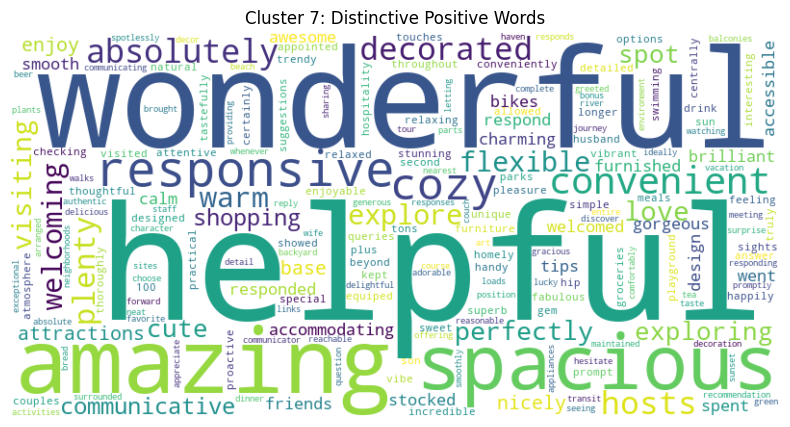

Saved: WordClouds15/C7N.png


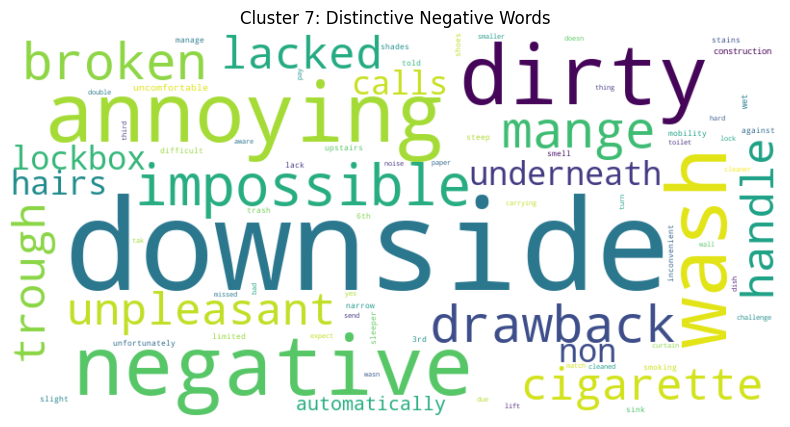

Saved: WordClouds15/C8P.png


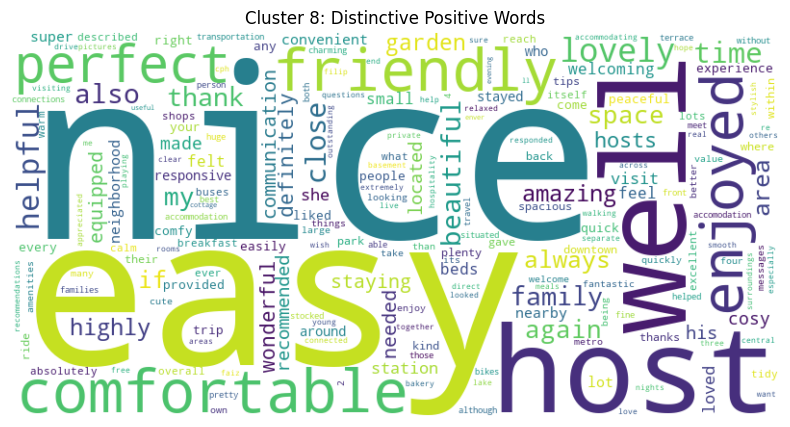

Saved: WordClouds15/C8N.png


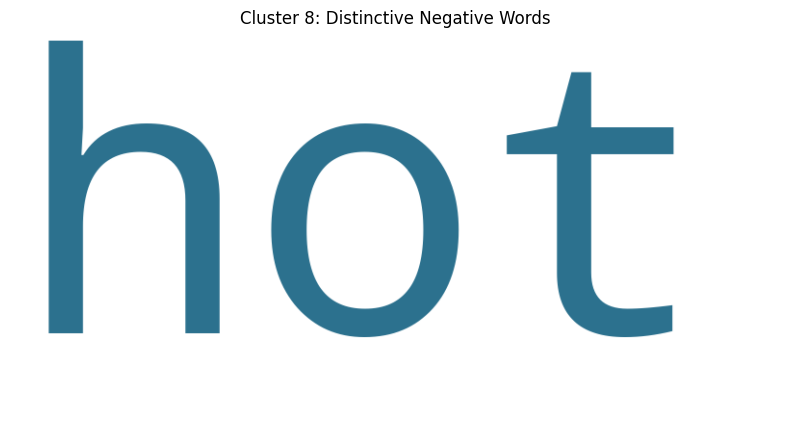

Saved: WordClouds15/C9P.png


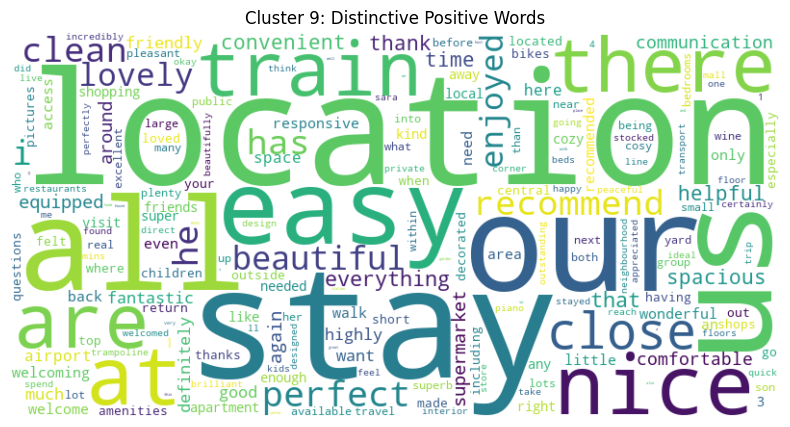

Cluster 9: Distinctive Negative Words: No distinctive words found.
Saved: WordClouds15/C10P.png


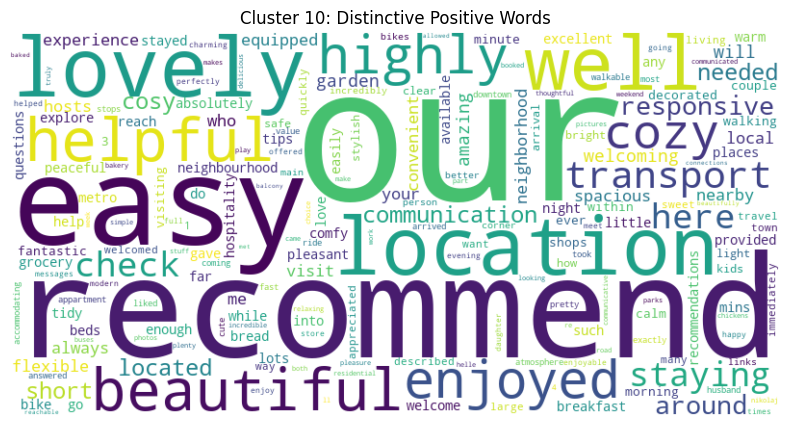

Saved: WordClouds15/C10N.png


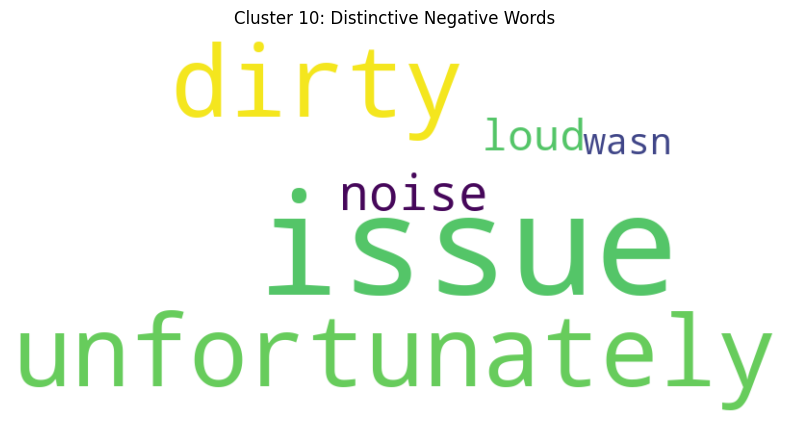

Saved: WordClouds15/C11P.png


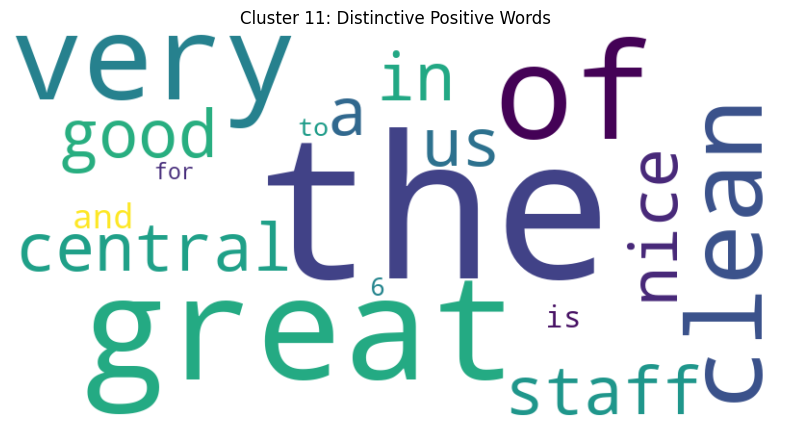

Cluster 11: Distinctive Negative Words: No distinctive words found.
Saved: WordClouds15/C12P.png


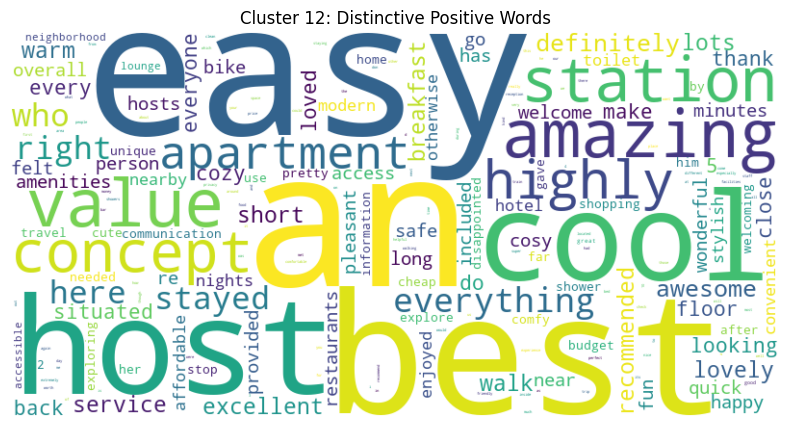

Saved: WordClouds15/C12N.png


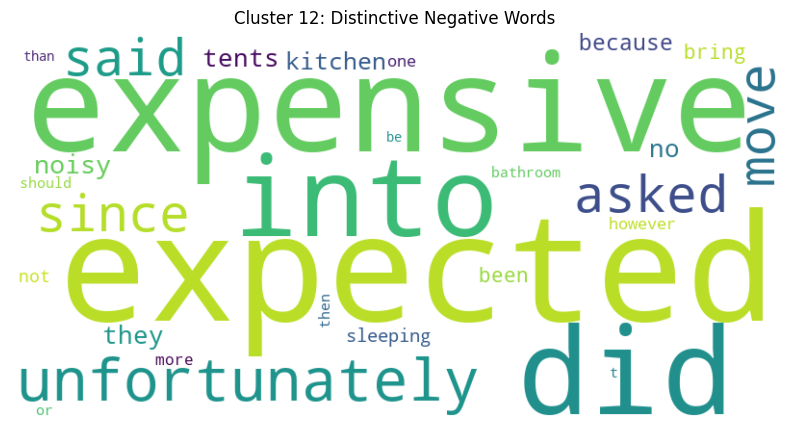

Saved: WordClouds15/C13P.png


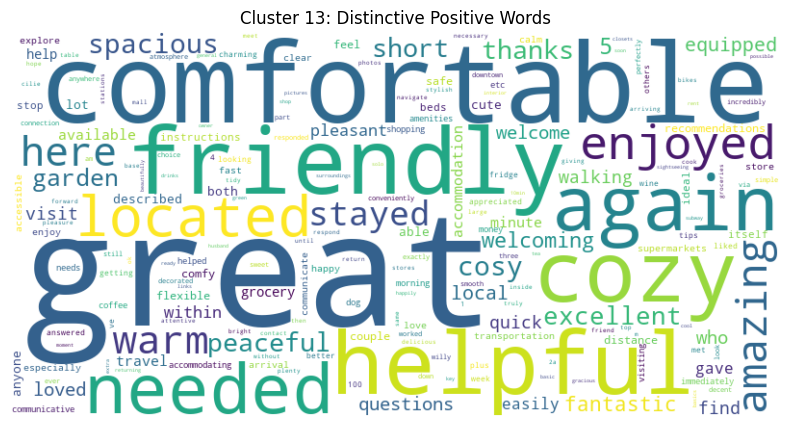

Saved: WordClouds15/C13N.png


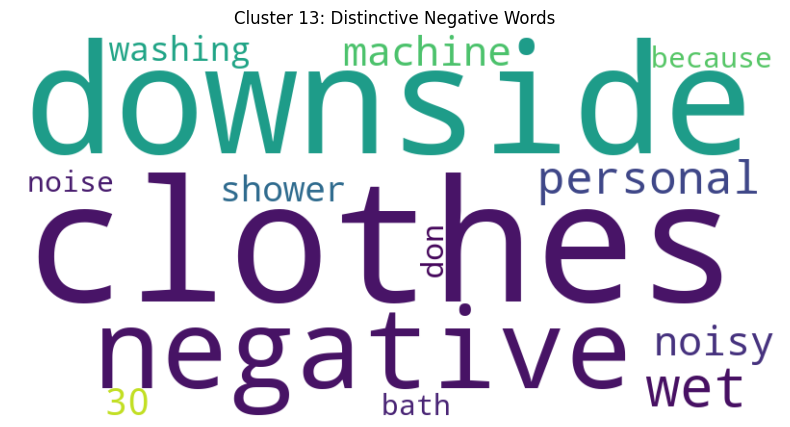

Saved: WordClouds15/C14P.png


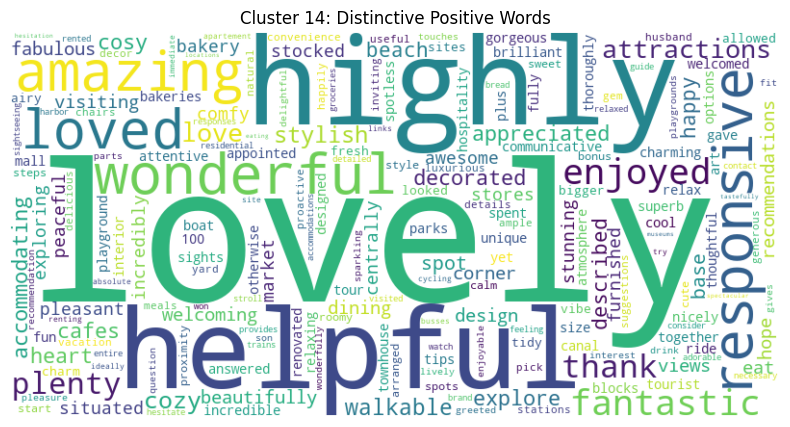

Saved: WordClouds15/C14N.png


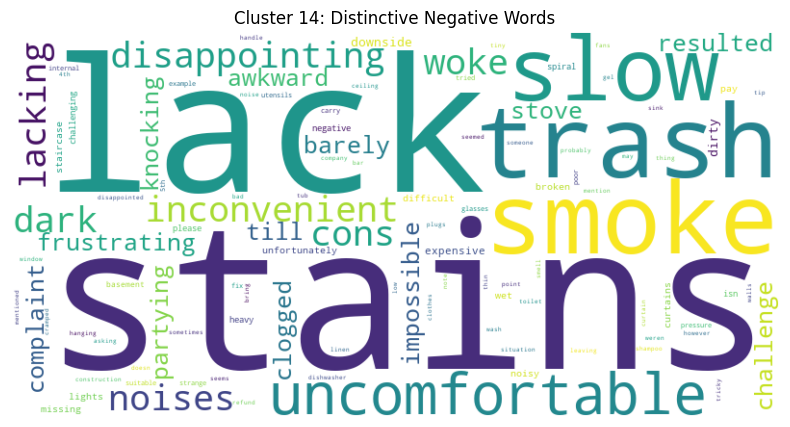

Saved: WordClouds15/C100P.png


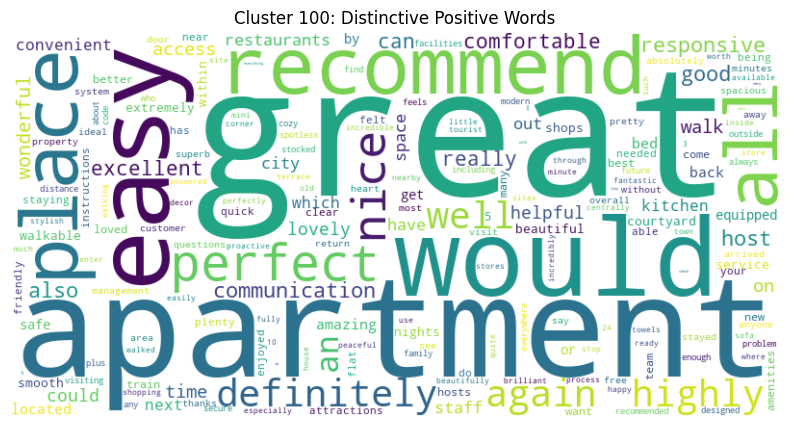

Saved: WordClouds15/C100N.png


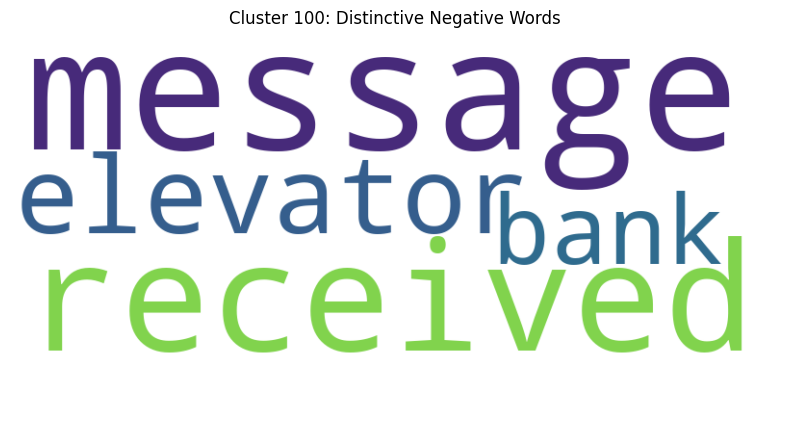

In [8]:
clusters = sorted(merged_df.cluster_kmeans.unique())
for k in clusters:

    # Positive and negative reviews inside cluster k
    pos_k = merged_df.loc[
        (merged_df.cluster_kmeans == k) &
        (merged_df.roberta_pos > merged_df.roberta_neg),
        "Review"
    ]

    neg_k = merged_df.loc[
        (merged_df.cluster_kmeans == k) &
        (merged_df.roberta_neg > merged_df.roberta_pos),
        "Review"
    ]

    # Compare positive vs negative within the cluster
    make_weighted_wc(
        pos_k, 
        neg_k, 
        f"Cluster {k}: Distinctive Positive Words",
        save_path=f"WordClouds15/C{k}P.png"
    )

    make_weighted_wc(
        neg_k, 
        pos_k, 
        f"Cluster {k}: Distinctive Negative Words",
        save_path=f"WordClouds15/C{k}N.png"
    )
